In [1]:
import numpy as np

In [2]:
import sys
sys.path.append("../")
from src import AtomCls, LTELib, ColExcite, SEsolver, OpticallyThin

restore atomic model

In [3]:
file = "../atom/C_III_Be_like.txt"
atom = AtomCls.Atom(file)

environment

In [4]:
Te = 2E+04
ne = 1E+10

compute the LTE population ratio first

In [10]:
#--- compute LTE population ratio for each CE transition
n_LTE = LTELib.get_LTE_ratio(_erg=atom.Level.erg[:], _g=atom.Level.g[:],
                _stage=atom.Level.stage[:], _Te=Te, _Ne=ne)

we are going to use LTE population ratio to convert `C_{ij}` to `C_{ji}` 

In [14]:
nTran = atom.CE_table.shape[0]
ni_LTE = np.empty(nTran, np.double)
nj_LTE = np.empty(nTran, np.double)

for k in range(nTran):
    ni_LTE[k] = n_LTE[atom.CE_coe.idxI[k]]
    nj_LTE[k] = n_LTE[atom.CE_coe.idxJ[k]]

In [15]:
#--- compute collision excitation/de-excitation rate coefficient
CE_fac = ColExcite.interpolate_CE_fac(_table=atom.CE_table[:,:], _Te=Te, _Te_table=atom.CE_Te_table[:],
                            _f1=atom.CE_coe.f1[:], _f2=atom.CE_coe.f2[:])
CEij = ColExcite.get_CE_rate_coe(_CE_fac=CE_fac, _Te=Te, _gi=atom.CE_coe.gi[:],
                            _dEij=atom.CE_coe.dEij[:], _type=atom.CE_type[0])

CEji = ColExcite.Cij_to_Cji(_Cij=CEij,  _ni_LTE=ni_LTE, _nj_LTE=nj_LTE)

solve SE equations under the assumption of "Corona equilibrium"

In [16]:
#--- solve SE equations
nLevel = atom.nLevel
Cmat = np.zeros((nLevel, nLevel), np.double)
Rmat = np.zeros((nLevel, nLevel), np.double)
SEsolver.setMatrixC(_Cmat=Cmat[:,:], _Cji=CEji[:], _Cij=CEij[:],
            _idxI=atom.CE_coe.idxI[:], _idxJ=atom.CE_coe.idxJ[:], _ne=ne)

Rji_stim = np.zeros(atom.Line.AJI[:].shape, np.double)
Rij = np.zeros(atom.Line.AJI[:].shape, np.double)
SEsolver.setMatrixR(_Rmat=Rmat[:,:], _Rji_spon=atom.Line.AJI[:],
    _Rji_stim=Rji_stim[:], _Rij=Rij, _idxI=atom.Line.idxI[:], _idxJ=atom.Line.idxJ[:])

n_SE = SEsolver.solveSE(_Rmat=Rmat[:,:], _Cmat=Cmat[:,:])

In [19]:
n_SE

array([8.96775533e-01, 1.13331681e-02, 3.25839437e-02, 5.93073531e-02,
       1.97509089e-09, 2.32240630e-11, 7.27437759e-11, 1.23079500e-10,
       2.90488204e-10, 1.35023619e-13])

compute relative flux for each transition

In [20]:
#-- compute optically thin relative flux
nj_SE = np.empty(nTran, np.double)
for k in range(nTran):
    nj_SE[k] = n_SE[atom.CE_coe.idxJ[k]]

rel_flux = OpticallyThin.get_relative_flux(_AJI=atom.Line.AJI[:], _f0=atom.Line.f0[:], _nj=nj_SE[:])

---

In [21]:
import matplotlib.pyplot as plt

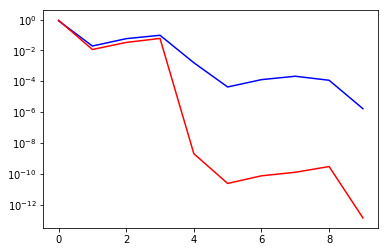

In [25]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(10), n_LTE, "-b", label="LTE")
ax.plot(np.arange(10), n_SE, "-r", label="SE")
ax.set_yscale("log")

---

In [11]:
Te = 5E+04

In [16]:
N = 13
ne_array = np.logspace(8,13,N,endpoint=True)

n_SE_array = np.empty((ne.shape[0], atom.nLevel), dtype=np.double)
rel_flux_array = np.empty((ne.shape[0], nTran), dtype=np.double)

for q in range(N):
    ne = ne_array[q]
    
    #--- compute LTE population ratio for each CE transition
    n_LTE = LTELib.get_LTE_ratio(_erg=atom.Level.erg[:], _g=atom.Level.g[:],
                    _stage=atom.Level.stage[:], _Te=Te, _Ne=ne)
    
    nTran = atom.CE_table.shape[0]
    ni_LTE = np.empty(nTran, np.double)
    nj_LTE = np.empty(nTran, np.double)

    for k in range(nTran):
        ni_LTE[k] = n_LTE[atom.CE_coe.idxI[k]]
        nj_LTE[k] = n_LTE[atom.CE_coe.idxJ[k]]
        
    #--- compute collision excitation/de-excitation rate coefficient
    CE_fac = ColExcite.interpolate_CE_fac(_table=atom.CE_table[:,:], _Te=Te, _Te_table=atom.CE_Te_table[:],
                                _f1=atom.CE_coe.f1[:], _f2=atom.CE_coe.f2[:])
    CEij = ColExcite.get_CE_rate_coe(_CE_fac=CE_fac, _Te=Te, _gi=atom.CE_coe.gi[:],
                                _dEij=atom.CE_coe.dEij[:], _type=atom.CE_type[0])

    CEji = ColExcite.Cij_to_Cji(_Cij=CEij,  _ni_LTE=ni_LTE, _nj_LTE=nj_LTE)
    
    #--- solve SE equations
    nLevel = atom.nLevel
    Cmat = np.zeros((nLevel, nLevel), np.double)
    Rmat = np.zeros((nLevel, nLevel), np.double)
    SEsolver.setMatrixC(_Cmat=Cmat[:,:], _Cji=CEji[:], _Cij=CEij[:],
                _idxI=atom.CE_coe.idxI[:], _idxJ=atom.CE_coe.idxJ[:], _ne=ne)

    Rji_stim = np.zeros(atom.Line.AJI[:].shape, np.double)
    Rij = np.zeros(atom.Line.AJI[:].shape, np.double)
    SEsolver.setMatrixR(_Rmat=Rmat[:,:], _Rji_spon=atom.Line.AJI[:],
        _Rji_stim=Rji_stim[:], _Rij=Rij, _idxI=atom.Line.idxI[:], _idxJ=atom.Line.idxJ[:])

    n_SE = SEsolver.solveSE(_Rmat=Rmat[:,:], _Cmat=Cmat[:,:])
    
    #-- compute optically thin relative flux
    nj_SE = np.empty(nTran, np.double)
    for k in range(nTran):
        nj_SE[k] = n_SE[atom.CE_coe.idxJ[k]]

    rel_flux = OpticallyThin.get_relative_flux(_AJI=atom.Line.AJI[:], _f0=atom.Line.f0[:], _nj=nj_SE[:])
    
    rel_flux_array[q,:] = rel_flux[:]

In [18]:
rel_flux_array.shape

(13, 45)

In [19]:
atom.Line.w0_AA

array([1.90959701e+03, 1.90873359e+03, 1.90668238e+03, 9.77019892e+02,
       7.27665811e+02, 7.27513892e+02, 7.27261985e+02, 6.85512991e+02,
       5.47885425e+02, 4.22145645e+06, 1.24921084e+06, 2.00060051e+03,
       1.17565934e+03, 1.17526283e+03, 1.17460558e+03, 1.06941479e+03,
       7.68327435e+02, 1.77424408e+06, 2.00154907e+03, 1.17598685e+03,
       1.17559012e+03, 1.17493250e+03, 1.06968577e+03, 7.68467300e+02,
       2.00380960e+03, 1.17676682e+03, 1.17636956e+03, 1.17571107e+03,
       1.07033107e+03, 7.68800285e+02, 2.85114232e+03, 2.84881142e+03,
       2.84495269e+03, 2.29757795e+03, 1.24738281e+03, 3.48465925e+06,
       1.31047644e+06, 1.18337128e+04, 2.21758058e+03, 2.10035873e+06,
       1.18740364e+04, 2.21899271e+03, 1.19415460e+04, 2.22133951e+03,
       2.72897783e+03])

1247 AA

In [22]:
atom.Line.w0_AA[34], atom.Line.idxI[34], atom.Line.idxJ[34]

(1247.38281, 4, 9)

In [23]:
atom.Level_info["configuration"][4], atom.Level_info["term"][4], atom.Level_info["J"][4]

('1s2.2s.2p', '1P', '1')

In [24]:
atom.Level_info["configuration"][9], atom.Level_info["term"][9], atom.Level_info["J"][9]

('1s2.2p2', '1S', '0')

1909 AA

In [27]:
atom.Line.w0_AA[1], atom.Line.idxI[1], atom.Line.idxJ[1]

(1908.73359, 0, 2)

In [26]:
atom.Level_info["configuration"][0], atom.Level_info["term"][0], atom.Level_info["J"][0]

('1s2.2s2', '1S', '0')

In [28]:
atom.Level_info["configuration"][2], atom.Level_info["term"][2], atom.Level_info["J"][2]

('1s2.2s.2p', '3P', '1')